# Visualisation of post and comments structure

#### 1. Documentation
- <>

#### 2. Examples
- <>

#### Libraries

In [1]:
#database management
import sqlite3
import pandas as pd
import numpy as np 

#data visualisation
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

# time functions
from datetime import datetime, timedelta
import datetime as dt

In [2]:
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

<span style="color:red"> Note about installing pygraphviz:</span> <br />
1. Install Vicrosoft Visual studio with C++ for Desktop  <br />
2. Run: conda install -c alubbock pygraphviz or pip install pydot <br />
3. Run: pip install graphviz

## 1. Most commented post

In [3]:
conn = sqlite3.connect("Data/trump_election.db")

In [4]:
# 1. Extracting and preparing the dataset:
trump_post_list = pd.read_sql('''SELECT distinct post_id, score
                                FROM Reddit
                                ORDER BY score DESC
                                limit 10''', conn) 
trump_post_list

,post_id,score
0,4cbbg8,32402
1,5i3c9k,32114
2,4ulrde,32027
3,4tx4ps,31969
4,5d9uc7,31861
5,577hd1,31778
6,52e421,31580
7,5c96xx,31409
8,4gjf6g,31349
9,5dmuhw,31287


## 2. Extracting data for a single post

In [5]:
post_code="52e421"

In [6]:
# 2. Full dataset
trump_posts = pd.read_sql('''SELECT time_label, time_group,
                                    id, parent_id
                                FROM Reddit
                                WHERE post_id= "'''+post_code+'''"
                                ORDER BY score DESC''', conn) 
trump_posts

,time_label,time_group,id,parent_id
0,<=8 hours,0,52e421,52e421
1,<=8 hours,0,d7jgus7,52e421
2,<=8 hours,0,d7jh1zt,d7jgus7
3,<=8 hours,0,d7jia2s,52e421
4,<=8 hours,0,d7jiy70,52e421
...,...,...,...,...
2576,<=8 hours,0,d7jr2wu,d7jo8fc
2577,<=8 hours,0,d7jojhg,d7jo8fc
2578,<=8 hours,0,d7jkio6,d7jjhw7
2579,<=8 hours,0,d7jhkd3,52e421


## 3. Visualisation

### 3.3 Drawing a radial tree with time indicators

In [7]:
def network_plot(df):
    
    """        
    The function visualises the networkx graph.

    Parameters:
        df_in: dataframe containing values
    """
    
    # 1. Creating a list for labels
    x=df.sort_values(by=["time_group"])
    label_values=x["time_label"].unique()

    # 2. Graph
    G = nx.from_pandas_edgelist(df=df, source="id", target="parent_id", create_using=nx.Graph() )
    # Node position
    pos = graphviz_layout(G, prog='twopi', root=post_code ) #post_code
            # Other options:
                # a) dot - filter for drawing directed graphs 
                # b) neato - filter for drawing undirected graphs 
                # c) twopi - filter for radial layouts of graphs 
                # d) circo - filter for circular layout of graphs 
                # e) fdp - filter for drawing undirected graphs 
                # f) sfdp - filter for drawing large undirected graphs 
                # g) patchwork - filter for tree maps 

    # 3. Labels and values
    carac = pd.DataFrame({'ID': df["id"], 'parameter': df["time_group"]})
    carac = carac.set_index('ID')
    carac = carac.reindex(G.nodes()) 

    # 4. Colors
    number_of_colors = len(carac['parameter'].unique())
    my_cmap = ListedColormap(sns.color_palette("tab20", n_colors=number_of_colors).as_hex())

    # 5. Node size
    ec = nx.eigenvector_centrality(G)
    max_ec=max(ec.values())
    node_size =  [np.log10(v/max_ec+1.03)*1000 for v in ec.values()] 

    # 6. Plot
    fig = plt.figure(figsize=(13, 7)) #plot size
    nx.draw(G, pos, node_color=carac['parameter'],  node_size=node_size, cmap=my_cmap, edge_color="grey")
    
    # 7. Colorbar
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=my_cmap), ticks=[])
    for num, lab in enumerate(label_values):
        cbar.ax.text(.5, 0.5/number_of_colors +num/number_of_colors, lab, ha='center', va='center', rotation=270, fontsize=10) 

    cbar.ax.get_yaxis().labelpad = 25 # how far is the legend title from the colorbar
    cbar.ax.set_ylabel('Time passed from post creation', rotation=270, fontsize=15)

    # Finalising
    fig.set_facecolor("#ffffff") 
    #plt.title("Typical comment structure of a post", fontsize=20)
    

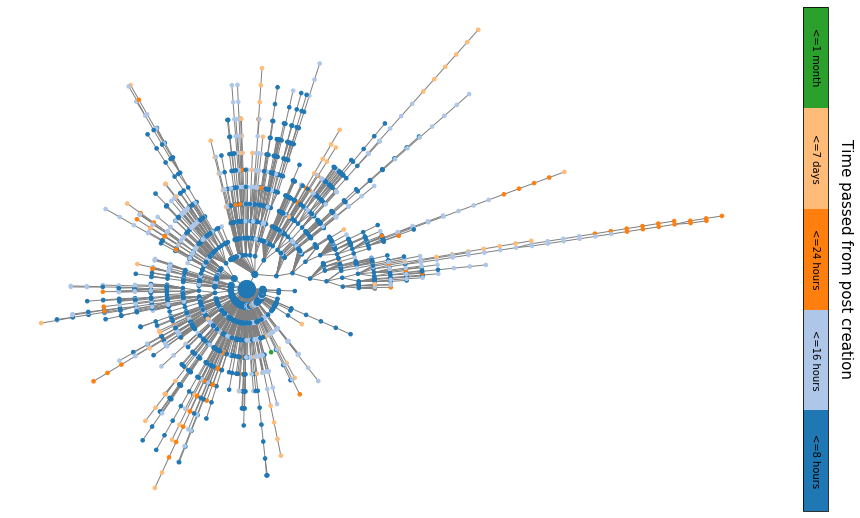

In [8]:
network_plot(trump_posts)
plt.savefig(r'Visualisations/4_1_network_structure.png', bbox_inches='tight')
plt.show()